## 라이브러리

In [46]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report as report

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
from xgboost import plot_importance
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay

from scipy.special import softmax

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import shap

import eli5
from eli5.sklearn import PermutationImportance

## 데이터 불러오기

In [2]:
prc = pd.read_csv('telecom_final.csv', encoding='euc-kr')
prc

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,...,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_extra_data_charges,total_long_distance_charges,total_revenue,churn
0,0,37,1,0,2,9,0,1,42.390000,0,...,2,1,1,1,65.60,593.30,0,381.51,974.81,0
1,1,46,0,0,0,9,0,1,10.690000,2,...,0,0,0,1,-4.00,542.40,10,96.21,610.28,0
2,1,50,0,0,0,4,5,1,33.650000,0,...,2,0,1,0,73.90,280.85,0,134.60,415.45,1
3,1,78,1,0,1,13,4,1,27.820000,0,...,2,0,1,0,98.00,1237.85,0,361.66,1599.51,1
4,0,75,1,0,3,3,0,1,7.380000,0,...,2,0,1,1,83.90,267.40,0,22.14,289.54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,0,36,0,0,0,4,0,1,2.010000,0,...,1,0,0,0,20.95,85.50,0,8.04,93.54,1
6585,0,20,0,0,0,13,4,1,46.680000,0,...,2,1,0,1,55.15,742.90,0,606.84,1349.74,0
6586,1,40,1,0,1,22,4,1,16.200000,2,...,2,0,1,0,85.10,1873.70,0,356.40,2230.10,1
6587,1,21,1,0,5,67,1,1,2.120000,0,...,2,2,0,1,67.85,4627.65,0,142.04,4769.69,0


# modeling

#### Split data

In [3]:
X = prc.drop(['churn'], axis = 1)
y = prc['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4612, 29) (1977, 29)
(4612,) (1977,)


#### scailing(표준화처리)

In [4]:
# 금액 칼럼 표준화
col = ['tenure_in_months', 'avg_monthly_long_distance_charges', 'monthly_charge', 'total_charges',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue']

from sklearn.preprocessing import StandardScaler # 데이터 전처리: 표준점수화하기

ss = StandardScaler()
ss.fit(X_train[col])

X_train[col] = ss.transform(X_train[col])
X_test[col] = ss.transform(X_test[col]) 

# 2. Building Models without optimization

In [5]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(tree_method = 'hist'),
    'LightGBM': LGBMClassifier(),
    'Bagging': BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10),
    'Support Vector Machine': SVC(probability=True)
}

## Without Cross Validation

In [6]:
# Fit and evaluate models

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = round(accuracy.mean(), 2)
    
    print(f'{model_name}:')
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred))
    print()

Logistic Regression:
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1416
           1       0.74      0.72      0.73       561

    accuracy                           0.85      1977
   macro avg       0.82      0.81      0.81      1977
weighted avg       0.85      0.85      0.85      1977


Decision Tree:
Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1416
           1       0.70      0.70      0.70       561

    accuracy                           0.83      1977
   macro avg       0.79      0.79      0.79      1977
weighted avg       0.83      0.83      0.83      1977


Random Forest:
Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1416
           1       0.85      0.65      0.74       561

    accuracy                           0.87      1977
   macro avg       0.86      0

## Adding K-fold : 교차검증

In [7]:
model_names = [] # 각 모델 이름 리스트
acc_results = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_results = []
pre_results = []
rec_results = []
f1_results = []

result_col = ["Algorithm", "Accuracy", "ROC AUC", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
model_results = pd.DataFrame(columns = result_col) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트

# Perform K-fold cross-validation
i=0
for model_name, model in models.items():
    model_names.append(model_name)
    kf = KFold(n_splits = 5)
    
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'roc_auc')
    cv_pre_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'precision')
    cv_rec_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
    cv_f1_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'f1')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    rec_results.append(cv_rec_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [model_name,
                            np.mean(acc_results),
                            np.mean(auc_results),
                            np.mean(pre_results),
                            np.mean(rec_results),
                            np.mean(f1_results)]

    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,Accuracy,ROC AUC,Precision,Recall,f1 Score
0,Logistic Regression,0.843887,0.906331,0.726191,0.721961,0.723605
6,Bagging,0.860706,0.903982,0.791369,0.701311,0.741448
5,LightGBM,0.859390,0.900629,0.782459,0.707590,0.741224
7,Support Vector Machine,0.852208,0.898720,0.786912,0.663831,0.714008
4,XGBoost,0.856246,0.894432,0.775990,0.704142,0.736202
3,Gradient Boosting,0.852288,0.886416,0.767661,0.700379,0.729979
2,Random Forest,0.843814,0.869245,0.744286,0.698913,0.718536
1,Decision Tree,0.831202,0.841088,0.695626,0.711620,0.706353


# 3. Tuning the parameters on each models

In [8]:
# build model
def build_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    auc_train = roc_auc_score(pred_train, y_train)
    auc_test = roc_auc_score(pred_test, y_test)
    # acc_train = accuracy_score(pred_train, y_train) # 훈련 세트 예측과 훈련 세트 실제 타겟 간의 정확도 확인
    # acc_test = accuracy_score(pred_test, y_test) # 테스트 세트 예측과 테스트 세트 실제 타겟 간의 정확도 확인
    
    print(f'Training roc_auc score {auc_train: .3f}') 
    print(f'Testing roc_auc score {auc_test: .3f}')
    
# tune parameters
def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_

# evaluating
def good_eval(X_train, X_test, y_train, y_test, goodmodel):
    goodmodel.fit(X_train, y_train)
    
    pred_goodmodel = goodmodel.predict(X_test)
    
    print('Results on test data: ')

    acc_ = accuracy_score(y_test, pred_goodmodel)
    pre_ = precision_score(y_test, pred_goodmodel)
    rec_ = recall_score(y_test, pred_goodmodel)
    auc_ = roc_auc_score(y_test, pred_goodmodel)

    print(f'Test accuracy = {acc_: .4f}') 
    print(f'Test precision = {pre_: .4f}') 
    print(f'Test recall = {rec_: .4f}') 
    print(f'Test auc = {auc_: .4f}')

    print("Classification report:")
    print(classification_report(y_test, pred_goodmodel))

    print("Confusion matrix (Rows actual, Columns predicted):")
    print(pd.DataFrame(confusion_matrix(y_test, pred_goodmodel)))
    
# roc plot
def roc_plot(model, X, y):
    print("ROC curve plot:")
    fig = plt.figure(figsize=(6,6))
    fig.set_facecolor('white')
    RocCurveDisplay.from_estimator(model, X, y)
    # ax.plot([0, 1], [0, 1], color='red', label='Random Model')
    plt.legend()
    plt.show()

## 3-1. Logistic Regression

#### Build model

In [9]:
lr = LogisticRegression(random_state = 42)
build_model(X_train, X_test, y_train, y_test, lr)

Training roc_auc score  0.811
Testing roc_auc score  0.818


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9136305451273965
- Best params: {'C': 1000, 'max_iter': 700}
- Best estimator:  LogisticRegression(C=1000, max_iter=700, random_state=42)
- Best score:  0.9103041187865166

In [10]:
param1 = {'C':[10, 100, 1000], 'max_iter': [100, 300, 500, 700, 900, 1100]}
tuning_params(X_train, y_train, params = param1, model = lr)

Accuracy
Train score: 0.8514744145706852
Best params: {'C': 100, 'max_iter': 300}
Best estimator:  LogisticRegression(C=100, max_iter=300, random_state=42)
Best score:  0.8499571095855962

ROC_AUC
Train score: 0.9136305451273965
Best params: {'C': 1000, 'max_iter': 700}
Best estimator:  LogisticRegression(C=1000, max_iter=700, random_state=42)
Best score:  0.9103041187865166


(LogisticRegression(C=100, max_iter=300, random_state=42),
 LogisticRegression(C=1000, max_iter=700, random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8518
Test precision =  0.7419
Test recall =  0.7326
Test auc =  0.8158
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1416
           1       0.74      0.73      0.74       561

    accuracy                           0.85      1977
   macro avg       0.82      0.82      0.82      1977
weighted avg       0.85      0.85      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1273  143
1   150  411
ROC curve plot:


<Figure size 600x600 with 0 Axes>

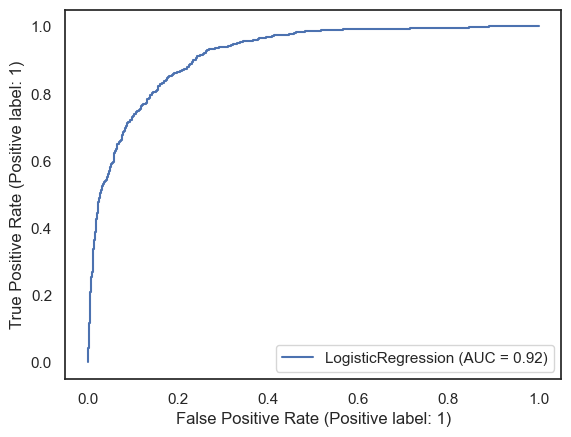

In [11]:
good_lr = LogisticRegression(C = 1000, max_iter = 700, random_state = 42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_lr)
roc_plot(model = good_lr, X = X_test, y = y_test)

## 3-2. Bagging

#### build model

In [12]:
# 순정
naive_bag = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42), 
                        random_state = 42, n_jobs = -1)
build_model(X_train, X_test, y_train, y_test, model = naive_bag)

Training roc_auc score  0.978
Testing roc_auc score  0.867


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9880607603794123
- Best params: {'max_samples': 2000, 'n_estimators': 150, 'oob_score': True}
- Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=2000, n_estimators=150, n_jobs=-1, oob_score=True,
                  random_state=42)
- Best score:  0.9250453329840532

In [13]:
param1 = [{'n_estimators': [100, 150, 200], 'max_samples': [1000, 2000], 'oob_score': [True, False]}]
tuning_params(X_train, y_train, params = param1, model = naive_bag)

# 노순정 : tuning_params(X_train, y_train, params = param1, model = bag)

Accuracy
Train score: 0.9336513443191674
Best params: {'max_samples': 2000, 'n_estimators': 150, 'oob_score': True}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=2000, n_estimators=150, n_jobs=-1, oob_score=True,
                  random_state=42)
Best score:  0.8690359409921904

ROC_AUC
Train score: 0.9880607603794123
Best params: {'max_samples': 2000, 'n_estimators': 150, 'oob_score': True}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=2000, n_estimators=150, n_jobs=-1, oob_score=True,
                  random_state=42)
Best score:  0.9250453329840532


(BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=2000, n_estimators=150, n_jobs=-1, oob_score=True,
                   random_state=42),
 BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=2000, n_estimators=150, n_jobs=-1, oob_score=True,
                   random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8746
Test precision =  0.8753
Test recall =  0.6506
Test auc =  0.8070
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1416
           1       0.88      0.65      0.75       561

    accuracy                           0.87      1977
   macro avg       0.87      0.81      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1364   52
1   196  365
ROC curve plot:


<Figure size 600x600 with 0 Axes>

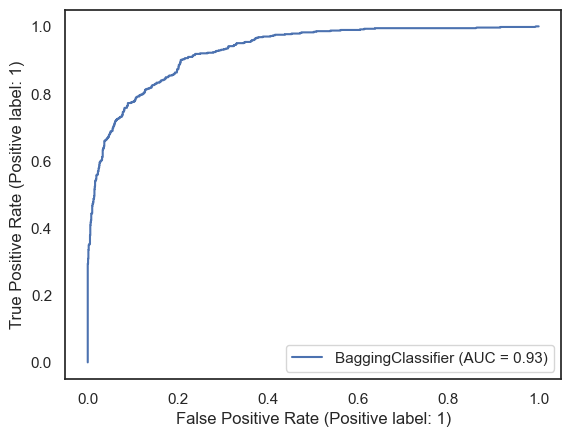

In [14]:
good_nbag = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42), 
                             max_samples=2000, n_estimators=150, n_jobs=-1, oob_score=True, random_state=42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_nbag)
roc_plot(model = good_nbag, X = X_test, y = y_test)

## 3-3. Random Forest

#### Build model

In [15]:
rf = RandomForestClassifier(random_state = 42)
build_model(X_train, X_test, y_train, y_test, rf)

Training roc_auc score  1.000
Testing roc_auc score  0.863


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9412053131779847
- Best params: {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 25}
- Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=25,
                       random_state=42)
- Best score:  0.9267538649741706

In [16]:
param1 = [{'n_estimators': [25, 50, 75],
           'max_features': [15, 20, 25],
           'max_leaf_nodes': [8, 16, 24]}]
tuning_params(X_train, y_train, params = param1, model = rf)

Accuracy
Train score: 0.8809627059843885
Best params: {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 75}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=75,
                       random_state=42)
Best score:  0.872939791258816

ROC_AUC
Train score: 0.9412053131779847
Best params: {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 25}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=25,
                       random_state=42)
Best score:  0.9267538649741706


(RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=75,
                        random_state=42),
 RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=25,
                        random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8715
Test precision =  0.8561
Test recall =  0.6578
Test auc =  0.8070
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1416
           1       0.86      0.66      0.74       561

    accuracy                           0.87      1977
   macro avg       0.87      0.81      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1354   62
1   192  369
ROC curve plot:


<Figure size 600x600 with 0 Axes>

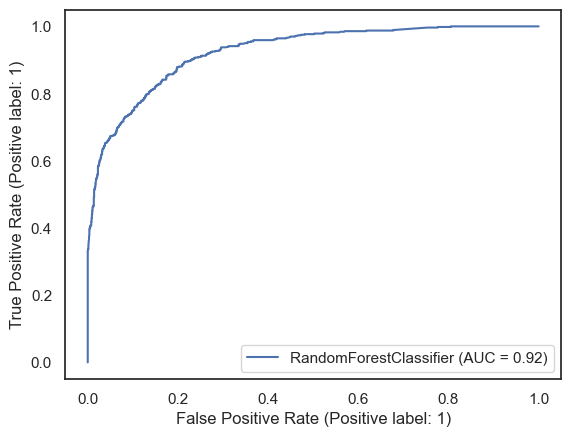

In [17]:
good_rf = RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=25, random_state=42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_rf)
roc_plot(model = good_rf, X = X_test, y = y_test)

#### Feature importance
- prc

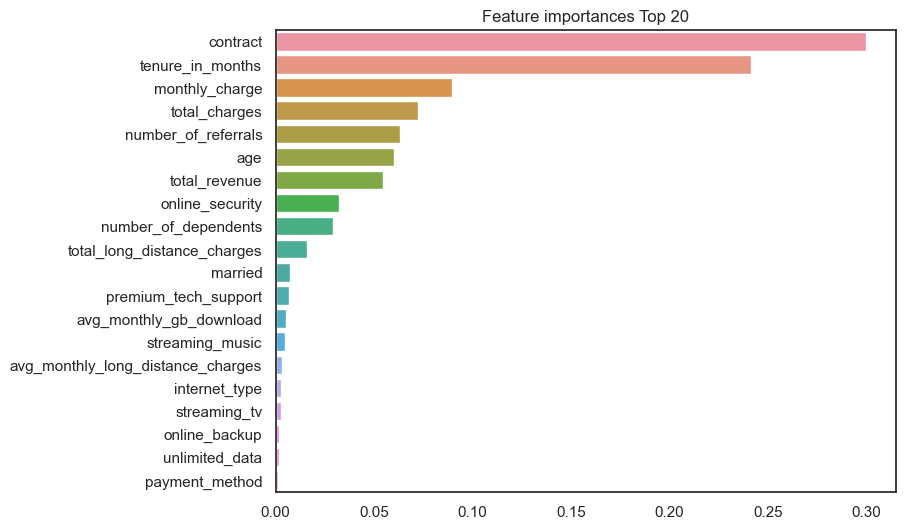

In [18]:
# 피쳐 중요도 시각화
importances_values = good_rf.feature_importances_
importances = pd.Series(importances_values, index=X_train.columns)
top20 = importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = top20, y = top20.index)
plt.show()

<AxesSubplot: >

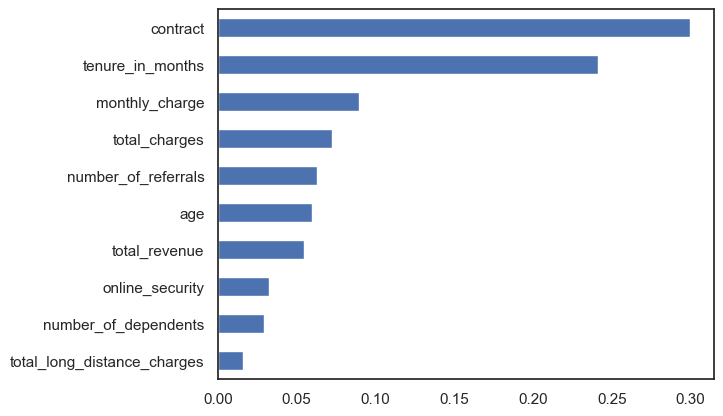

In [19]:
importances = good_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## 3-4. Decision Tree

In [20]:
dt = DecisionTreeClassifier()
build_model(X_train, X_test, y_train, y_test, dt)

Training roc_auc score  1.000
Testing roc_auc score  0.785


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9329425781741713
- Best params: {'criterion': 'entropy', 'max_depth': 6}
- Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=6)
- Best score:  0.9084099565873285

In [21]:
param1 = {'criterion':['gini', 'entropy'], 'max_depth':[None,2,3,4,5,6]}
tuning_params(X_train, y_train, params = param1, model = dt)

Accuracy
Train score: 0.8679531656548135
Best params: {'criterion': 'entropy', 'max_depth': 6}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=6)
Best score:  0.8560310973130625

ROC_AUC
Train score: 0.9329425781741713
Best params: {'criterion': 'entropy', 'max_depth': 6}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=6)
Best score:  0.9084099565873285


(DecisionTreeClassifier(criterion='entropy', max_depth=6),
 DecisionTreeClassifier(criterion='entropy', max_depth=6))

#### Evaluating

Results on test data: 
Test accuracy =  0.8493
Test precision =  0.7903
Test recall =  0.6381
Test auc =  0.7855
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1416
           1       0.79      0.64      0.71       561

    accuracy                           0.85      1977
   macro avg       0.83      0.79      0.80      1977
weighted avg       0.85      0.85      0.84      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1321   95
1   203  358
ROC curve plot:


<Figure size 600x600 with 0 Axes>

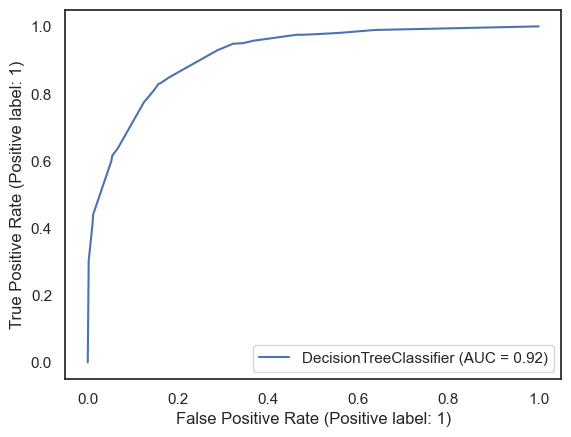

In [22]:
good_dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_dt)
roc_plot(model = good_dt, X = X_test, y = y_test)

#### Feature Importance
- prc

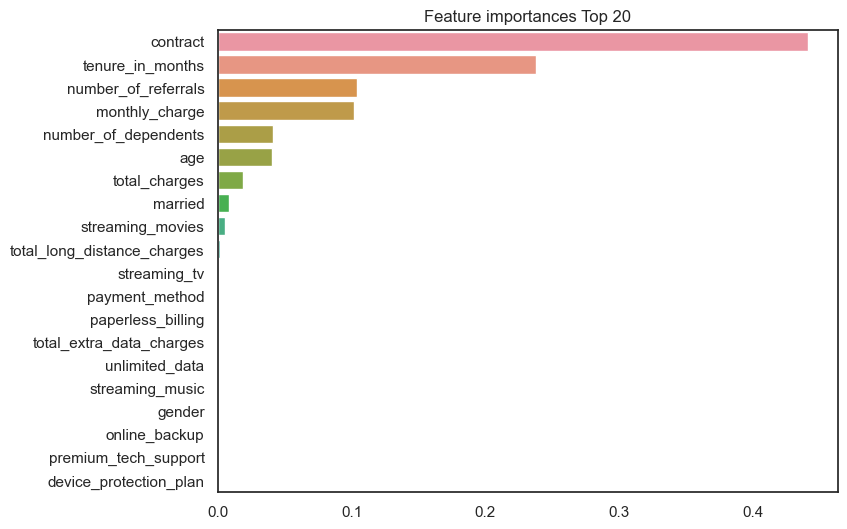

In [63]:
# 피쳐 중요도 시각화
importances_values = good_dt.feature_importances_
importances = pd.Series(importances_values, index=X_train.columns)
top20 = importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = top20, y = top20.index)
plt.show()

<AxesSubplot: >

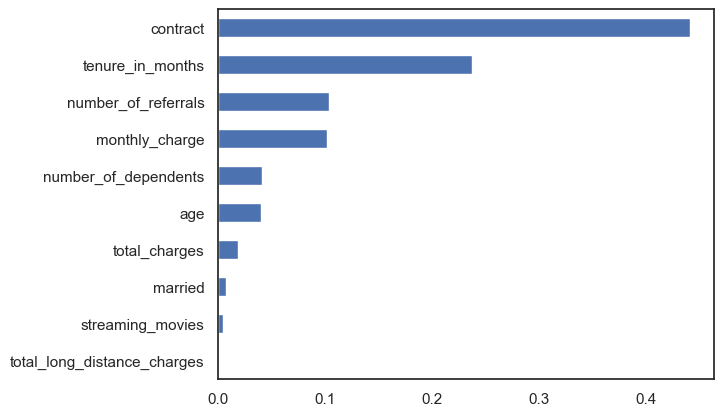

In [24]:
importances = good_dt.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## 3-5. Support Vector Machine

In [25]:
svmc = SVC(random_state = 42, probability=True)
build_model(X_train, X_test, y_train, y_test, model=svmc)

Training roc_auc score  0.787
Testing roc_auc score  0.797


#### Tuning the parameters

In [ ]:
param1 = [{'kernel':['linear', 'rbf'], 'gamma':[1, 0.1, 0, 0.3, 0.5, 0.7], 'C':[1, 10, 100]}]
tuning_params(X_train, y_train, params = param1, model = svmc)

#### Evaluating

Results on test data: 
Test accuracy =  0.8518
Test precision =  0.7359
Test recall =  0.7451
Test auc =  0.8196
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1416
           1       0.74      0.75      0.74       561

    accuracy                           0.85      1977
   macro avg       0.82      0.82      0.82      1977
weighted avg       0.85      0.85      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1266  150
1   143  418
ROC curve plot:


<Figure size 600x600 with 0 Axes>

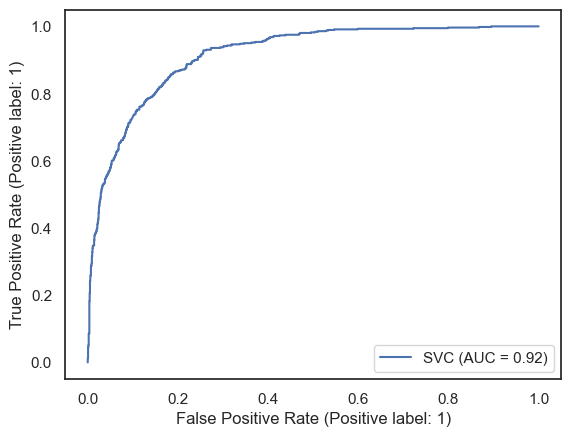

In [41]:
good_svm = SVC(random_state = 42, probability=True, C = 1, kernel = 'linear', gamma = 0.1)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_svm)
roc_plot(model = good_svm, X = X_test, y = y_test)

## 3-6. Gradient Boosting

#### Building model

In [29]:
gb = GradientBoostingClassifier(random_state = 42)
build_model(X_train, X_test, y_train, y_test, model = gb)

Training roc_auc score  0.892
Testing roc_auc score  0.863


#### Tuning the parameter
- ROC_AUC
- Train score: 0.959111395880075
- Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- Best estimator:  GradientBoostingClassifier(random_state=42)
- Best score:  0.9384091741141202

In [30]:
param1 = [{'n_estimators': [80, 100, 150, 200, 500],
         'learning_rate': [0.1, 0.2, 0.3],
         'max_depth': [1, 3, 5, 7, 9]}]
tuning_params(X_train, y_train, params = param1, model = gb)

Accuracy
Train score: 0.9592367736339983
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best estimator:  GradientBoostingClassifier(n_estimators=500, random_state=42)
Best score:  0.8816104704314658

ROC_AUC
Train score: 0.959111395880075
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  GradientBoostingClassifier(random_state=42)
Best score:  0.9384091741141202


(GradientBoostingClassifier(n_estimators=500, random_state=42),
 GradientBoostingClassifier(random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8751
Test precision =  0.8413
Test recall =  0.6898
Test auc =  0.8191
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1416
           1       0.84      0.69      0.76       561

    accuracy                           0.88      1977
   macro avg       0.86      0.82      0.84      1977
weighted avg       0.87      0.88      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1343   73
1   174  387
ROC curve plot:


<Figure size 600x600 with 0 Axes>

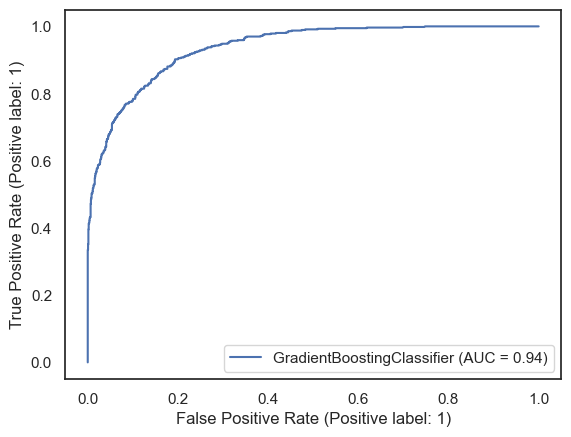

In [31]:
good_gb = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, max_depth = 3, random_state=42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_gb)
roc_plot(model = good_gb, X = X_test, y = y_test)

#### Feature importance

## 3-7. XGBoost

#### Building model

In [32]:
xgb = XGBClassifier(tree_method = 'hist', random_state = 42)
build_model(X_train, X_test, y_train, y_test, model = xgb)

Training roc_auc score  0.998
Testing roc_auc score  0.834


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9541557448667541
- Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
- Best score:  0.937429546649323

In [33]:
param1 = [{'n_estimators': [100, 300, 500, 700],
           'learning_rate': [0.1, 0.2, 0.3],
           'max_depth': [1, 3, 5, 7, 9]}]
tuning_params(X_train, y_train, params = param1, model = xgb)

Accuracy
Train score: 0.9241110147441457
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best score:  0.8787914538792911

ROC_AUC
Train score: 0.9541557448667541
Best params: {'learning_rate': 0.1, 'max_depth': 3

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=300, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric

#### Evaluating

[0]	validation_0-logloss:0.64248
[1]	validation_0-logloss:0.60085
[2]	validation_0-logloss:0.56641
[3]	validation_0-logloss:0.53627
[4]	validation_0-logloss:0.51026
[5]	validation_0-logloss:0.48874
[6]	validation_0-logloss:0.46970
[7]	validation_0-logloss:0.45296
[8]	validation_0-logloss:0.43778
[9]	validation_0-logloss:0.42547
[10]	validation_0-logloss:0.41407
[11]	validation_0-logloss:0.40325
[12]	validation_0-logloss:0.39338
[13]	validation_0-logloss:0.38483
[14]	validation_0-logloss:0.37677
[15]	validation_0-logloss:0.36974
[16]	validation_0-logloss:0.36382
[17]	validation_0-logloss:0.35786
[18]	validation_0-logloss:0.35258
[19]	validation_0-logloss:0.34727
[20]	validation_0-logloss:0.34171
[21]	validation_0-logloss:0.33753
[22]	validation_0-logloss:0.33383
[23]	validation_0-logloss:0.33059
[24]	validation_0-logloss:0.32740
[25]	validation_0-logloss:0.32485
[26]	validation_0-logloss:0.32257
[27]	validation_0-logloss:0.32012
[28]	validation_0-logloss:0.31687
[29]	validation_0-loglos

<Figure size 600x600 with 0 Axes>

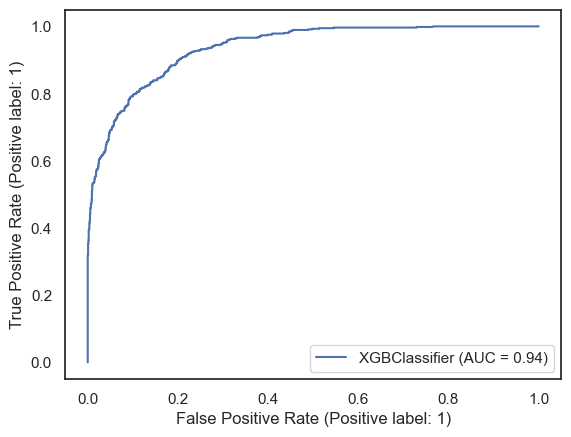

In [34]:
good_xgb = XGBClassifier(tree_method = 'hist', learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42)

evals = [(X_test, y_test)]
good_xgb.fit(X_train, y_train, 
             early_stopping_rounds = 100, eval_metric="logloss", eval_set = evals, verbose=True)
pred_xgb = good_xgb.predict(X_test)


print('Results on test data: ')

acc_xgb = accuracy_score(y_test, pred_xgb)
pre_xgb = precision_score(y_test, pred_xgb)
rec_xgb = recall_score(y_test, pred_xgb)
auc_xgb = roc_auc_score(y_test, pred_xgb)

print(f'Test accuracy = {acc_xgb: .4f}') 
print(f'Test precision = {pre_xgb: .4f}') 
print(f'Test recall = {rec_xgb: .4f}') 
print(f'Test auc = {auc_xgb: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_xgb))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_xgb)))

roc_plot(model = good_xgb, X = X_test, y = y_test)

#### Feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

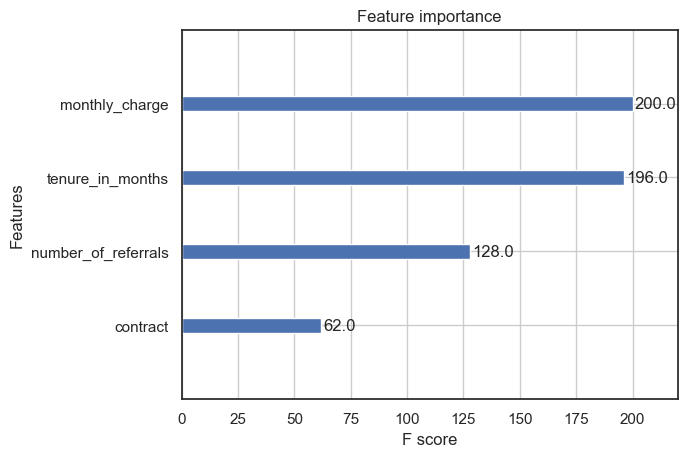

In [60]:
fig, ax = plt.subplots()
plot_importance(good_xgb, ax = ax)

## 3-8. LightGBM

#### Building model

In [35]:
lgbm = LGBMClassifier(random_state = 42)
build_model(X_train, X_test, y_train, y_test, lgbm)

Training roc_auc score  0.973
Testing roc_auc score  0.845


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9556067013572651
- Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- Best estimator:  LGBMClassifier(max_depth=3, random_state=42)
- Best score:  0.9375551593733104

In [36]:
param1 = {'learning_rate': [0.1, 0.2, 0.3],
          'max_depth': [1, 3, 5, 7, 9],
          'n_estimators': [100, 300, 500, 700]}
tuning_params(X_train, y_train, params = param1, model = lgbm)#### Tuning the parameters

Accuracy
Train score: 0.8933217692974849
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  LGBMClassifier(max_depth=3, random_state=42)
Best score:  0.8787930989910764

ROC_AUC
Train score: 0.9556067013572651
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  LGBMClassifier(max_depth=3, random_state=42)
Best score:  0.9375551593733104


(LGBMClassifier(max_depth=3, random_state=42),
 LGBMClassifier(max_depth=3, random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8771
Test precision =  0.8442
Test recall =  0.6952
Test auc =  0.8222
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1416
           1       0.84      0.70      0.76       561

    accuracy                           0.88      1977
   macro avg       0.87      0.82      0.84      1977
weighted avg       0.87      0.88      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1344   72
1   171  390
ROC curve plot:


<Figure size 600x600 with 0 Axes>

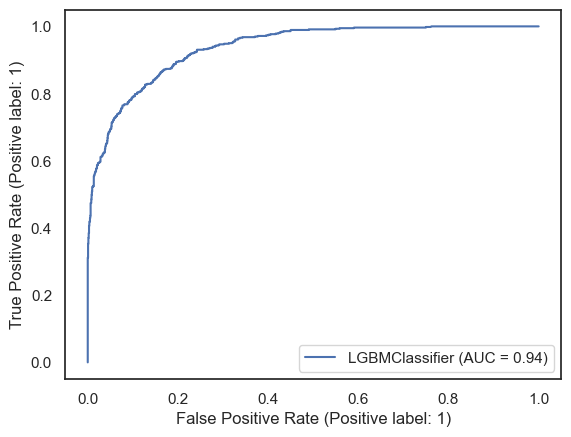

In [37]:
good_lgbm = LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_lgbm)
roc_plot(model = good_lgbm, X = X_test, y = y_test)#### Evaluating

#### Feature importance

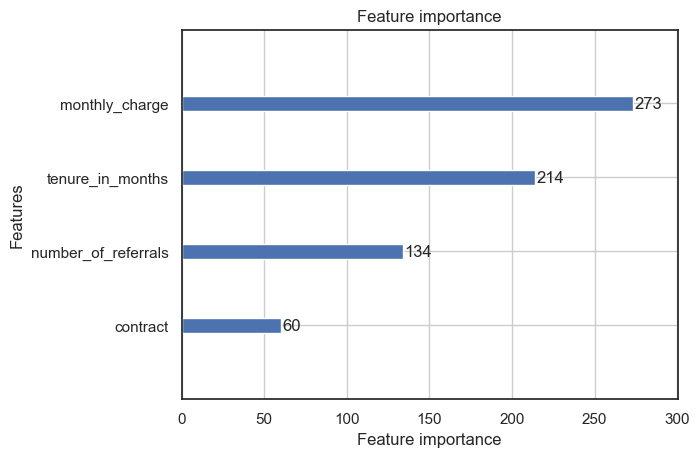

In [68]:
plot_importance(good_lgbm)
plt.show()

# 4. Finding good model (테스트 세트)

In [38]:
models = {
    'Logistic Regression': LogisticRegression(C = 10, max_iter = 900, random_state = 42),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=6),
    'Random Forest': RandomForestClassifier(max_features=25, max_leaf_nodes=24, n_estimators=75, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 5, random_state = 42),
    'XGBoost': XGBClassifier(tree_method = 'hist', learning_rate = 0.1, max_depth = 3, n_estimators = 500, random_state = 42),
    'LightGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42),
    'Support Vector Machine': SVC(random_state = 42, probability=True, C = 1, kernel = 'linear', gamma = 0.1),
    'Bagging': BaggingClassifier(base_estimator=RandomForestClassifier(), 
                        n_estimators=10, oob_score = True, bootstrap = True, random_state = 42, n_jobs = -1)
}

In [42]:
# train set
model_names_opt = [] # 각 모델 이름 리스트
acc_opt = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_opt = []
pre_opt = []
rec_opt = []
f1_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
results_opt = pd.DataFrame(columns = result_col_opt) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트


i=0
for model_name, model in models.items():
    model_names_opt.append(model_name)
    kf = KFold(n_splits = 5)
    
    acc_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
    auc_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'roc_auc')
    pre_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'precision')
    rec_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
    f1_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'f1')

    acc_opt.append(acc_results_opt)
    auc_opt.append(auc_results_opt)
    pre_opt.append(pre_results_opt)
    rec_opt.append(rec_results_opt)
    f1_opt.append(f1_results_opt)
    
    results_opt.loc[i] = [model_name,
                            np.mean(auc_results_opt),
                            np.mean(acc_results_opt),
                            np.mean(pre_results_opt),
                            np.mean(rec_results_opt),
                            np.mean(f1_results_opt)]

    i+=1

results_opt.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,Recall,f1 Score
5,LightGBM,0.937455,0.875975,0.829641,0.708736,0.762888
4,XGBoost,0.932379,0.876410,0.821162,0.721900,0.767227
3,Gradient Boosting,0.931213,0.870122,0.811640,0.705762,0.754055
2,Random Forest,0.925116,0.870773,0.839073,0.674126,0.746428
7,Bagging,0.924786,0.871423,0.848095,0.665880,0.745126
6,Support Vector Machine,0.910531,0.847358,0.724428,0.745077,0.734298
0,Logistic Regression,0.909960,0.849741,0.731653,0.741947,0.736417
1,Decision Tree,0.902879,0.853864,0.788510,0.672285,0.722563


In [43]:
# test set
model_names_opt = [] # 각 모델 이름 리스트
acc_opt = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_opt = []
pre_opt = []
rec_opt = []
f1_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
results_opt = pd.DataFrame(columns = result_col_opt) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트


i=0
for model_name, model in models.items():
    model_names_opt.append(model_name)
    kf = KFold(n_splits = 5)
    
    acc_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'accuracy')
    auc_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'roc_auc')
    pre_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'precision')
    rec_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'recall')
    f1_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'f1')

    acc_opt.append(acc_results_opt)
    auc_opt.append(auc_results_opt)
    pre_opt.append(pre_results_opt)
    rec_opt.append(rec_results_opt)
    f1_opt.append(f1_results_opt)
    
    results_opt.loc[i] = [model_name,
                            np.mean(auc_results_opt),
                            np.mean(acc_results_opt),
                            np.mean(pre_results_opt),
                            np.mean(rec_results_opt),
                            np.mean(f1_results_opt)]

    i+=1

results_opt.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,Recall,f1 Score
5,LightGBM,0.926070,0.865463,0.804240,0.692332,0.743515
7,Bagging,0.916497,0.858372,0.816884,0.645608,0.720705
4,XGBoost,0.915531,0.850284,0.763518,0.682104,0.720144
2,Random Forest,0.913857,0.858375,0.812085,0.650060,0.721874
3,Gradient Boosting,0.911053,0.844204,0.764030,0.651945,0.702449
6,Support Vector Machine,0.910091,0.844723,0.722418,0.734429,0.727876
0,Logistic Regression,0.909646,0.847251,0.729415,0.732659,0.730704
1,Decision Tree,0.895326,0.841176,0.771106,0.635850,0.692407


# 5-1. ROC Curve

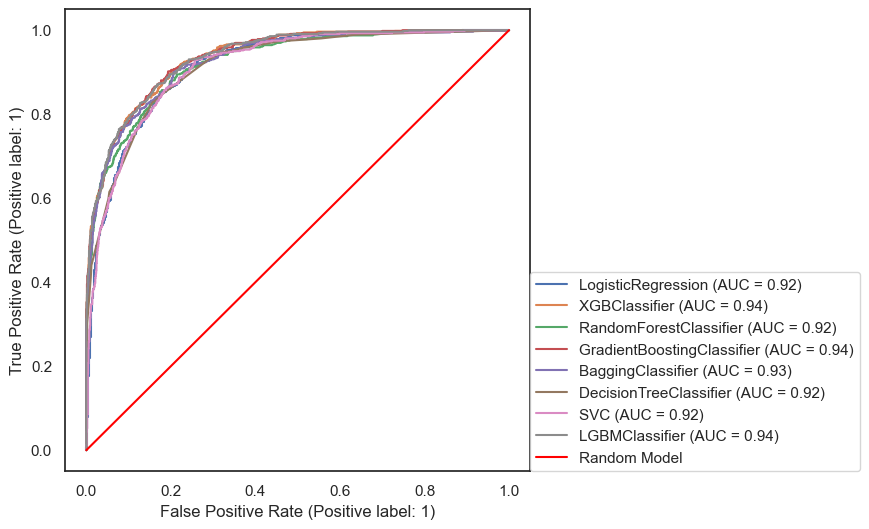

In [44]:
# roc plot
fig = plt.figure(figsize=(6,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
RocCurveDisplay.from_estimator(good_lr, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_xgb, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_rf, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_gb, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_nbag, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_dt, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_svm, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_lgbm, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], color='red', label='Random Model')
ax.legend(loc = [1.0, 0])
plt.show()

# 5. SHAP for feature importance
**Permutation Importance** <br>
- 모델 재학습 시킬 필요 없음
- 특성 제거 대신 특정 특성을 permutate 해서 노이즈로 만듦
- permutating particular features to explore the differences between predicted values and real values and moreover the effect of the relevant features.
- if trained model are too dependent on the relevant features, then predict-accuracy would greatly decrease.
    - in other words, lower performance & crucial features
- each feature importance != partial importance
    - each feature importance includes the relation/ interactions with other features

Interpreting Permutation Importances
- The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).
- The number after the ± measures how performance varied from one-reshuffling to the next.
- You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. 

## 5-1. Model Evaluating using Feature Importances (Random Forest)

### Permutation Importance

In [47]:
perm = PermutationImportance(good_rf, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0668 ± 0.0078,contract
0.0511 ± 0.0072,tenure_in_months
0.0345 ± 0.0078,monthly_charge
0.0267 ± 0.0043,number_of_referrals
0.0216 ± 0.0049,age
0.0085 ± 0.0029,number_of_dependents
0.0026 ± 0.0017,streaming_music
0.0008 ± 0.0019,online_security
0.0008 ± 0.0027,total_long_distance_charges
0.0006 ± 0.0010,multiple_lines


### Visualization - Feature Importance

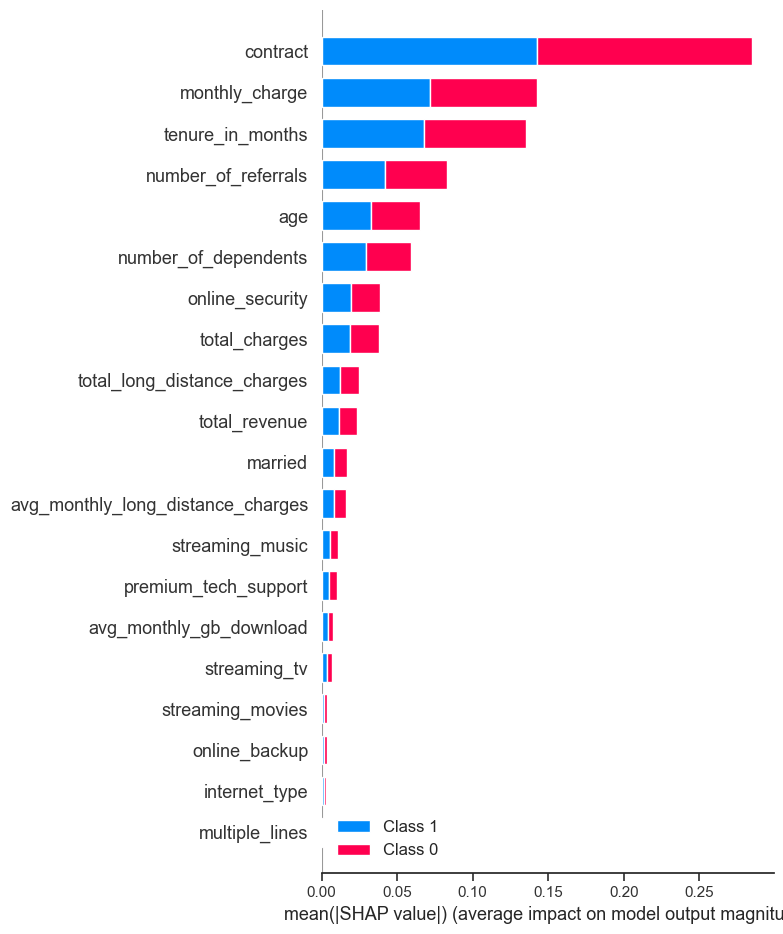

In [48]:
explainer = shap.TreeExplainer(good_rf)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_train)
plt.show()

### 특성중요도 기준 모델 평가

In [49]:
prc1 = prc.query('monthly_charge >= 0')
X1 = prc1.drop(['churn'], axis=1)
y1 = prc1['churn']
train_X1, val_X1, train_y1, val_y1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
good_modelRF = good_rf.fit(train_X1, train_y1)

Results on test data
Test accuracy =  0.8700
Test precision =  0.8378
Test recall =  0.6720
Test auc =  0.8102
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1416
           1       0.84      0.67      0.75       561

    accuracy                           0.87      1977
   macro avg       0.86      0.81      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1343   73
1   184  377

ROC curve


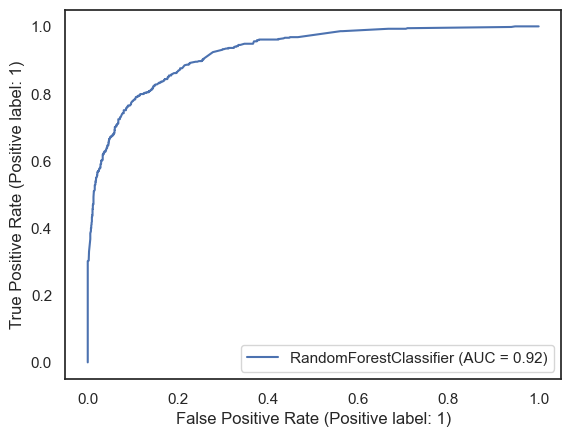

In [50]:
imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals', 'age', 'number_of_dependents', 'online_security']
                    # age 부터는 넣나 안넣나 0.92 고정
# Specify non-default hyper-parameter values

good_modelRF.fit(X_train[imp_features], y_train) # train model
pred = good_modelRF.predict(X_test[imp_features]) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
pre = precision_score(y_test, pred) # precision on test examples
rec = recall_score(y_test, pred) # recall on test examples
auc = roc_auc_score(y_test, pred) # roc_auc on test examples

print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {pre: .4f}') # round to 4 decimal places
print(f'Test recall = {rec: .4f}') # round to 4 decimal places
print(f'Test auc = {auc: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_modelRF, X_test[imp_features], y_test)
plt.show()

## 5-2. Model Evaluating using Feature Importances (Gradient Boosting)

In [51]:
perm = PermutationImportance(good_gb, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0995 ± 0.0152,tenure_in_months
0.0471 ± 0.0092,contract
0.0306 ± 0.0066,number_of_referrals
0.0246 ± 0.0062,monthly_charge
0.0158 ± 0.0036,number_of_dependents
0.0132 ± 0.0022,age
0.0036 ± 0.0037,online_security
0.0027 ± 0.0041,premium_tech_support
0.0020 ± 0.0020,payment_method
0.0012 ± 0.0019,avg_monthly_gb_download


<AxesSubplot: >

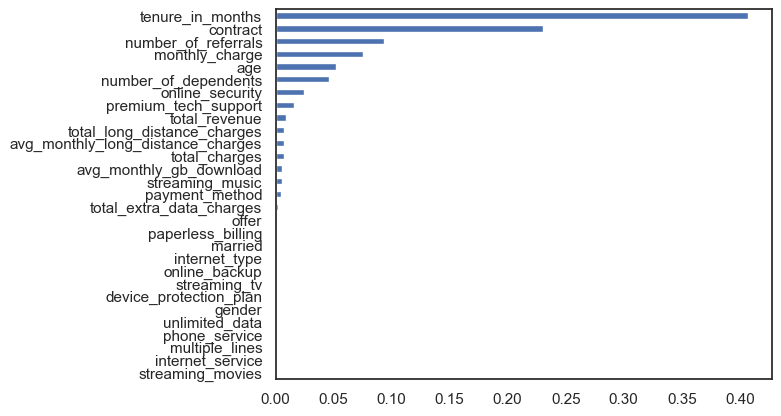

In [52]:
# 특성중요도 시각화
importances = good_gb.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[:].plot(kind = 'barh')

Results on test data
Test accuracy =  0.8563
Test precision =  0.7978
Test recall =  0.6613
Test auc =  0.7975
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1416
           1       0.80      0.66      0.72       561

    accuracy                           0.86      1977
   macro avg       0.84      0.80      0.81      1977
weighted avg       0.85      0.86      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1322   94
1   190  371

ROC curve


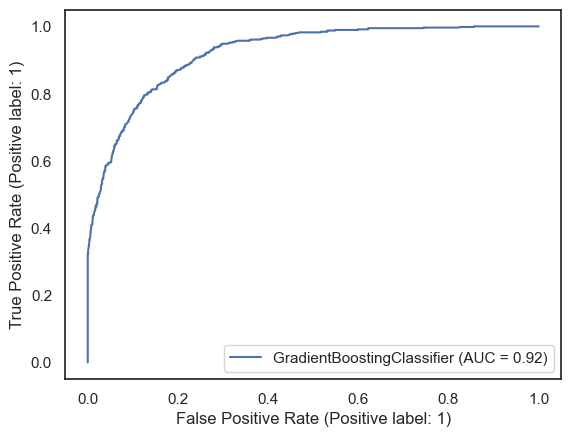

In [53]:
# base_features= ['age','number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
#                'avg_monthly_gb_download','online_security', 'online_backup',
#                'premium_tech_support', 'unlimited_data', 'contract', 'paperless_billing',
#                'payment_method', 'monthly_charge', 'total_charges', 'total_long_distance_charges', 'total_revenue']
# X2 = prc2[base_features]
# y2 = prc2.churn
prc2 = prc
X2 = prc2.drop(['churn'], axis=1)
y2 = prc2['churn']
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, test_size=0.3, random_state = 42)
good_modelGB = good_gb.fit(train_X2, train_y2)

imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals']

good_modelGB.fit(X_train[imp_features], y_train) # train model
pred = good_modelGB.predict(X_test[imp_features]) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
pre = precision_score(y_test, pred) # precision on test examples
rec = recall_score(y_test, pred) # recall on test examples
auc = roc_auc_score(y_test, pred) # roc_auc on test examples

print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {pre: .4f}') # round to 4 decimal places
print(f'Test recall = {rec: .4f}') # round to 4 decimal places
print(f'Test auc = {auc: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_modelGB, X_test[imp_features], y_test)
plt.show()

## 5-3. Model Evaluating using Feature Importances (LGBM)

In [54]:
perm = PermutationImportance(good_lgbm, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0916 ± 0.0178,tenure_in_months
0.0477 ± 0.0066,contract
0.0315 ± 0.0080,number_of_referrals
0.0281 ± 0.0026,monthly_charge
0.0140 ± 0.0058,number_of_dependents
0.0119 ± 0.0039,age
0.0048 ± 0.0039,online_security
0.0044 ± 0.0039,married
0.0035 ± 0.0035,premium_tech_support
0.0020 ± 0.0009,avg_monthly_long_distance_charges


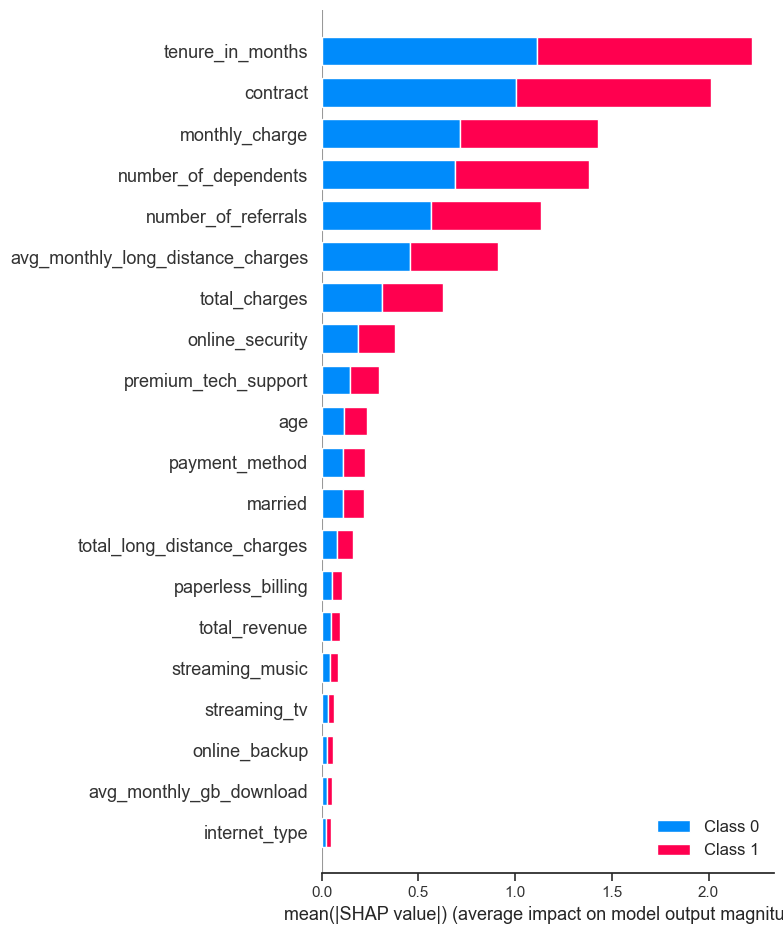

In [55]:
explainer = shap.TreeExplainer(good_lgbm)
shap_values = explainer.shap_values(X)
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_train)
plt.show()

Results on test data
Test accuracy =  0.8538
Test precision =  0.7906
Test recall =  0.6595
Test auc =  0.7952
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1416
           1       0.79      0.66      0.72       561

    accuracy                           0.85      1977
   macro avg       0.83      0.80      0.81      1977
weighted avg       0.85      0.85      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1318   98
1   191  370

ROC curve


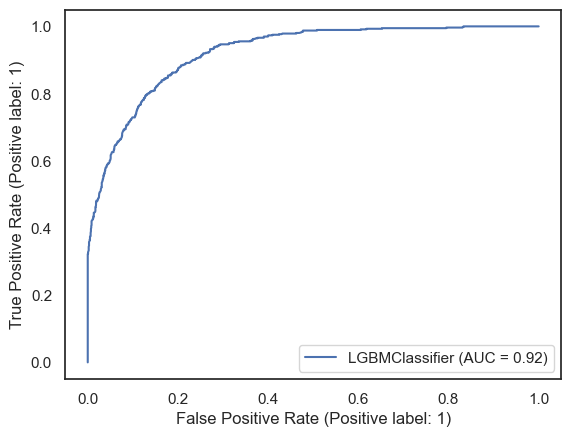

In [56]:
# prc2 = prc.query('monthly_charge >= 0')
# y2 = prc2.churn
# base_features= ['age','number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
#                 'avg_monthly_gb_download','online_security', 'online_backup',
#                 'premium_tech_support', 'unlimited_data', 'contract', 'paperless_billing',
#                 'payment_method', 'monthly_charge', 'total_charges', 'total_long_distance_charges', 'total_revenue']
# X2 = prc2[base_features]

prc2 = prc
X2 = prc2.drop(['churn'], axis=1)
y2 = prc2['churn']
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, random_state = 42)
good_modelLGBM = good_lgbm.fit(train_X2, train_y2)

imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals']

good_modelLGBM.fit(X_train[imp_features], y_train) # train model
pred = good_modelLGBM.predict(X_test[imp_features]) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
pre = precision_score(y_test, pred) # precision on test examples
rec = recall_score(y_test, pred) # recall on test examples
auc = roc_auc_score(y_test, pred) # roc_auc on test examples

print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {pre: .4f}') # round to 4 decimal places
print(f'Test recall = {rec: .4f}') # round to 4 decimal places
print(f'Test auc = {auc: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_modelLGBM, X_test[imp_features], y_test)
plt.show()

## 5-4. Model Evaluating using Feature Importances (XGBoost)

In [57]:
perm = PermutationImportance(good_xgb, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0862 ± 0.0211,tenure_in_months
0.0485 ± 0.0080,contract
0.0347 ± 0.0083,number_of_referrals
0.0238 ± 0.0014,monthly_charge
0.0140 ± 0.0044,number_of_dependents
0.0132 ± 0.0023,age
0.0056 ± 0.0036,online_security
0.0034 ± 0.0023,married
0.0029 ± 0.0026,premium_tech_support
0.0025 ± 0.0034,streaming_tv


<AxesSubplot: >

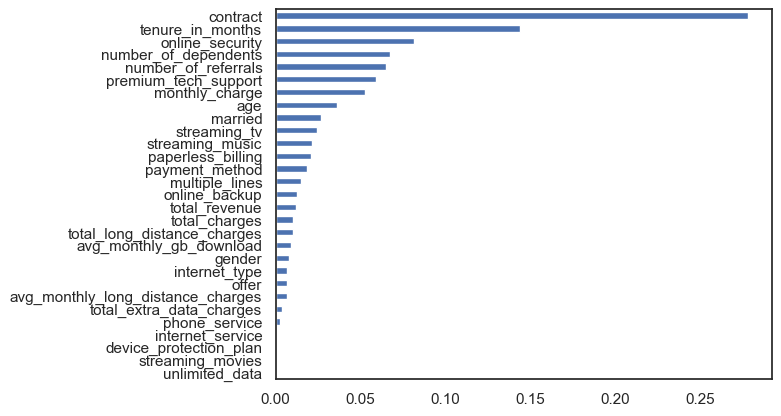

In [58]:
# 특성중요도 시각화
importances = good_xgb.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[:].plot(kind = 'barh')

Results on test data
Test accuracy =  0.8569
Test precision =  0.7983
Test recall =  0.6631
Test auc =  0.7984
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1416
           1       0.80      0.66      0.72       561

    accuracy                           0.86      1977
   macro avg       0.84      0.80      0.81      1977
weighted avg       0.85      0.86      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
      0    1
0  1322   94
1   189  372

ROC curve


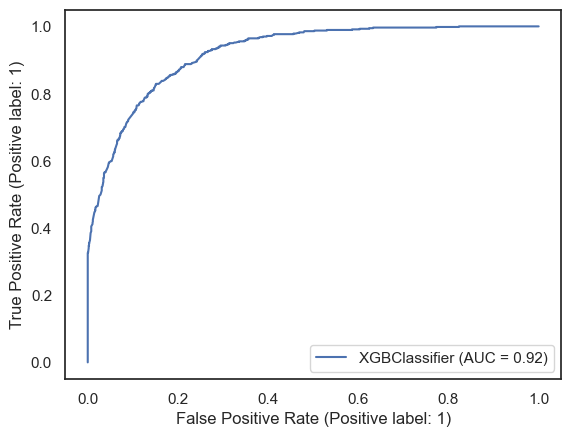

In [59]:
prc2 = prc
X2 = prc2.drop(['churn'], axis=1)
y2 = prc2['churn']
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, random_state = 42)
good_modelXGB = good_xgb.fit(train_X2, train_y2)

imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals']

good_modelXGB.fit(X_train[imp_features], y_train) # train model
pred = good_modelXGB.predict(X_test[imp_features]) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
pre = precision_score(y_test, pred) # precision on test examples
rec = recall_score(y_test, pred) # recall on test examples
auc = roc_auc_score(y_test, pred) # roc_auc on test examples

print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {pre: .4f}') # round to 4 decimal places
print(f'Test recall = {rec: .4f}') # round to 4 decimal places
print(f'Test auc = {auc: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_modelXGB, X_test[imp_features], y_test)
plt.show()